In [2]:
# !pip install ../..

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython import display

from generation.config import SIGNALS_TRAINING_CONFIG as CONFIG
from generation.dataset.signals_dataset import SignalsDataset

In [4]:
config = CONFIG

dataset = SignalsDataset(signal_dim=config['x_dim'])

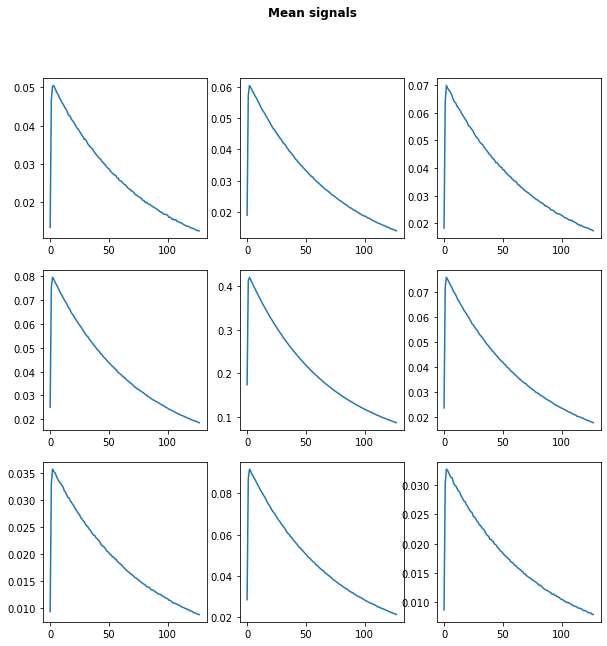

In [5]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle("Mean signals", weight='bold')

mean_signals = np.mean(dataset.signals, axis=1)

for i, signal in enumerate(mean_signals):
    ax[i // 3][i % 3].plot(mean_signals[i])
plt.show()

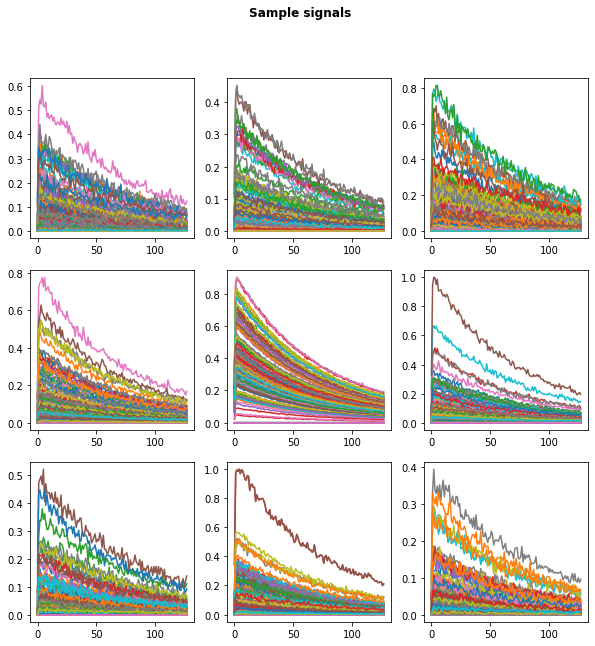

In [6]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle("Sample signals", weight='bold')

for _ in range(250):
    noises = dataset.signals[:, np.random.choice(range(len(dataset)))]
    for i in range(9):
        ax[i // 3][i % 3].plot(noises[i])
plt.show()

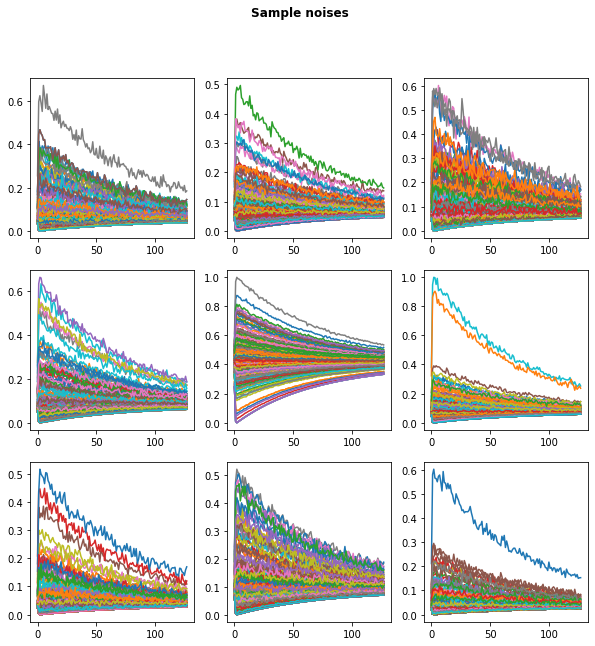

In [9]:
f, ax = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle("Sample noises", weight='bold')

for _ in range(250):
    noises = dataset.noises[:, np.random.choice(range(len(dataset)))]
    for i in range(9):
        ax[i // 3][i % 3].plot(noises[i])
plt.show()

In [10]:
for item in dataset:
    f, ax = plt.subplots(3, 3, figsize=(10, 10))

    for i in range(9):
        signal = item[i]
        ax[i // 3][i % 3].plot(signal)
    
    display.clear_output(wait=True)
    plt.show()

KeyboardInterrupt: 

### How does a noise depend on amplitude?

In [12]:
signal = dataset.signals[0][0]
signal_dim = len(signal)
np.convolve(signal, np.ones(signal_dim) / signal_dim, mode='valid')

array([0.06758234])

In [23]:
def smooth(x, window_len=11, window='flat'):
    """
    smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError

    if x.size < window_len:
        raise ValueError


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [82]:
import time

import tqdm

WINDOW_LEN = 5
DETECTOR = 0
EPS = 1e-10


diffs = []
for signals in tqdm.tqdm(dataset):
    signal = np.array(signals[DETECTOR])
    signal /= (np.max(signal) + EPS)
    smooth_signal = smooth(signal, WINDOW_LEN)[WINDOW_LEN//2: -WINDOW_LEN//2 + 1]
    assert len(signal) == len(smooth_signal)
    diffs.append(np.sqrt(np.sum((signal - smooth_signal) ** 2)))
#     plt.plot(signal)
#     plt.plot(smooth_signal)
#     display.clear_output(wait=True)
#     time.sleep(1)
#     plt.show()

diffs = np.array(diffs)

100%|██████████| 8310/8310 [00:01<00:00, 6223.86it/s]


In [83]:
def plot_random_signal(diffs, min_threshold, max_threshold):
    signals = dataset.signals[DETECTOR]
    threshold_signals = signals[(diffs > min_threshold) & (diffs < max_threshold)]
    random_idx = np.random.choice(range(len(threshold_signals)))
    random_signal = threshold_signals[random_idx]
    plt.plot(random_signal)
    plt.show()

(array([3486.,  356., 1678., 1321.,  739.,  430.,  155.,  101.,   30.,
          14.]),
 array([0.        , 0.34500838, 0.69001676, 1.03502514, 1.38003352,
        1.7250419 , 2.07005028, 2.41505866, 2.76006704, 3.10507541,
        3.45008379]),
 <a list of 10 Patch objects>)

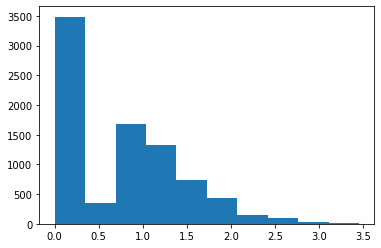

In [84]:
plt.hist(diffs)

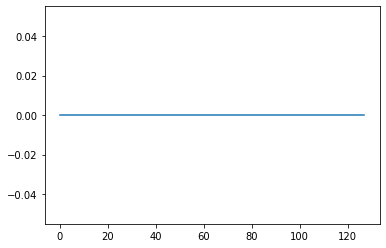

In [103]:
plot_random_signal(diffs, -0.01, 0.4)

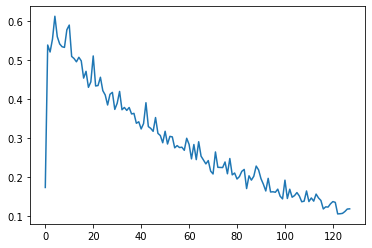

In [106]:
plot_random_signal(diffs, 0.4, 0.6)

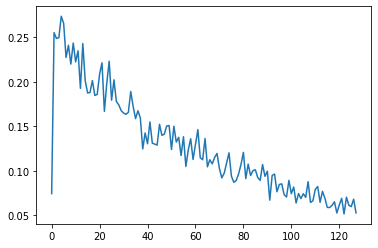

In [107]:
plot_random_signal(diffs, 0.6, 0.8)

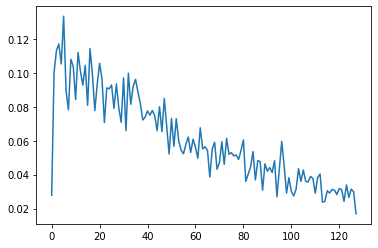

In [108]:
plot_random_signal(diffs, 0.8, 1.0)

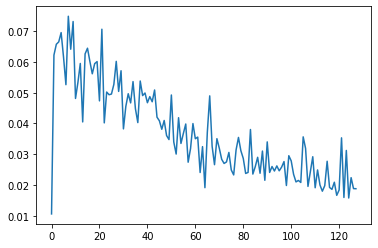

In [109]:
plot_random_signal(diffs, 1.0, 1.2)

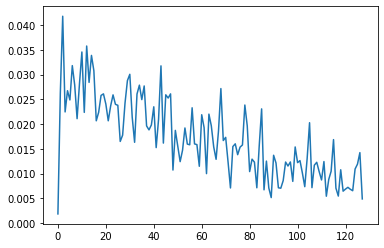

In [110]:
plot_random_signal(diffs, 1.2, 1.4)

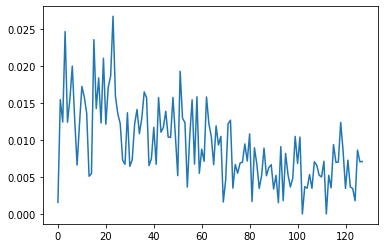

In [111]:
plot_random_signal(diffs, 1.4, 1.6)